In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# EDA (pandas-profiling, etc. )
from statsmodels.genmod.families import Binomial
from scipy.stats import pointbiserialr
import scipy.stats as stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,LabelEncoder
from sklearn.metrics import confusion_matrix

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # type: ignore 
from sklearn.metrics import classification_report,accuracy_score

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import RandomizedSearchCV

# Other packages
import os, joblib
from joblib import load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('D:\PROJETOS\APIMED\Dataset\Patients_Files_Train.csv')
df.head() # preview the data

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\luizg\AppData\Local\Temp\ipykernel_4100\3912397243.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\PROJETOS\APIMED\Dataset\Patients_Files_Train.csv')


,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [4]:
# view basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [5]:
# Vamos ver algumas estatísticas do nosso conjunto de dados

df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


In [6]:
# verifique se nossos dados possuem valores nulos
df.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [7]:
# verifique se há duplicatas

df.duplicated().sum()

0

In [8]:
df['Insurance'].unique()

array([0, 1], dtype=int64)

In [9]:
# Vamos verificar valores únicos no alvo

df['Sepssis'].unique()

array(['Positive', 'Negative'], dtype=object)

In [10]:
# 'Sepse' deve ser uma variável binária (0 para negativo, 1 para positivo)

df_copy = df.copy()
df_copy['Sepssis'] = df_copy['Sepssis'].replace({'Negative': 0, 'Positive': 1})

# Calcular o coeficiente de correlação ponto-bisserial
correlation_coefficient, p_value = stats.pointbiserialr(df_copy['Sepssis'], df_copy['PRG'])

# Print o resultado
print(f"Point-Biserial Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Defina o nível de significância (5%)
alpha = 0.05

# Determine se a correlação é estatisticamente significativa
if p_value < alpha:
    print("Existe uma correlação significativa entre sepse e PRG.")
else:
    print("Não há correlação significativa entre sepse e PRG.")

Point-Biserial Correlation Coefficient: 0.2071
P-value: 0.0000
Existe uma correlação significativa entre sepse e PRG.


# Distribuição de dados de sepse

In [11]:
sepsis_data = df['Sepssis'].value_counts()
sepsis_data

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64

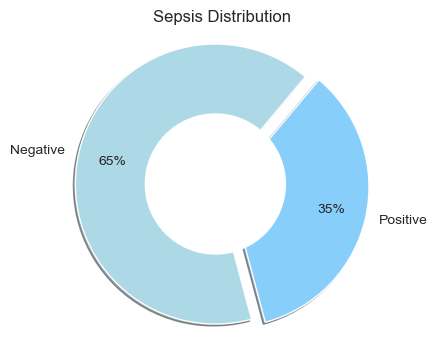

In [12]:
# Crie um gráfico de pizza usando pyplot para visualizar a distribuição da sepse

plt.figure(figsize=(4, 4))

plt.pie(sepsis_data, labels=['Negative','Positive'], colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Sepsis Distribution')
plt.show()

# Distribuição de dados de seguros

In [13]:
insurance_data = df['Insurance'].value_counts()
insurance_data

Insurance
1    411
0    188
Name: count, dtype: int64

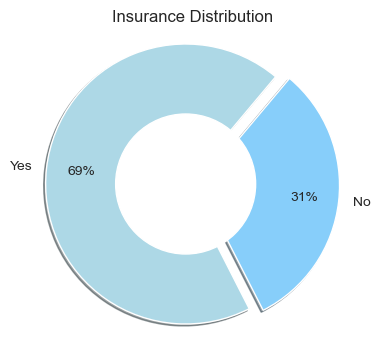

In [14]:
# Crie um gráfico de pizza usando pyplot para visualizar a distribuição de seguros

plt.figure(figsize=(4, 4))

plt.pie(insurance_data, labels=['Yes','No'], colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Proporção igual garante que o gráfico de pizza seja desenhado como um círculo.
plt.title('Insurance Distribution')
plt.show()

# Distribuição de outras colunas

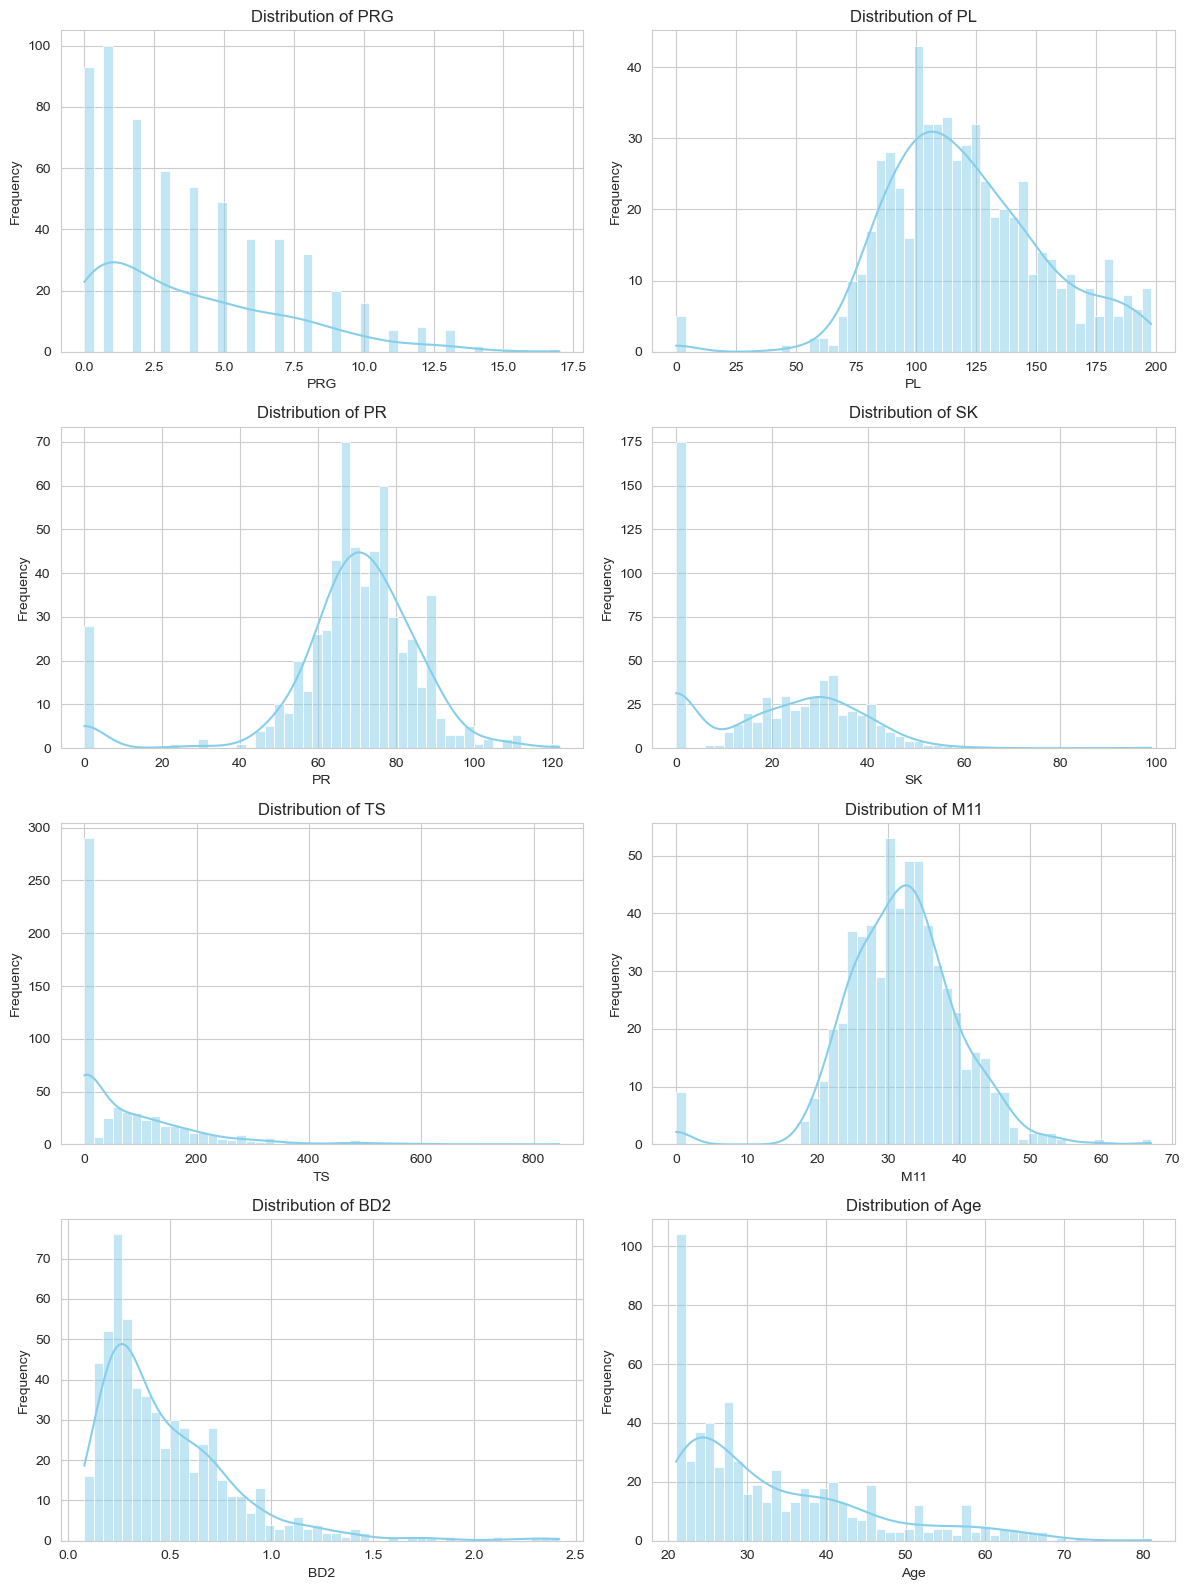

In [15]:
# Create histograms with KDE plots to visualize distribution of other columns

cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Calculate the number of rows needed
num_rows = len(cols) // 2 + len(cols) % 2

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate over columns and create histograms with KDE plots
for i, column in enumerate(cols):
    sns.histplot(df[column], kde=True, bins=50, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of subplots is odd
if len(cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

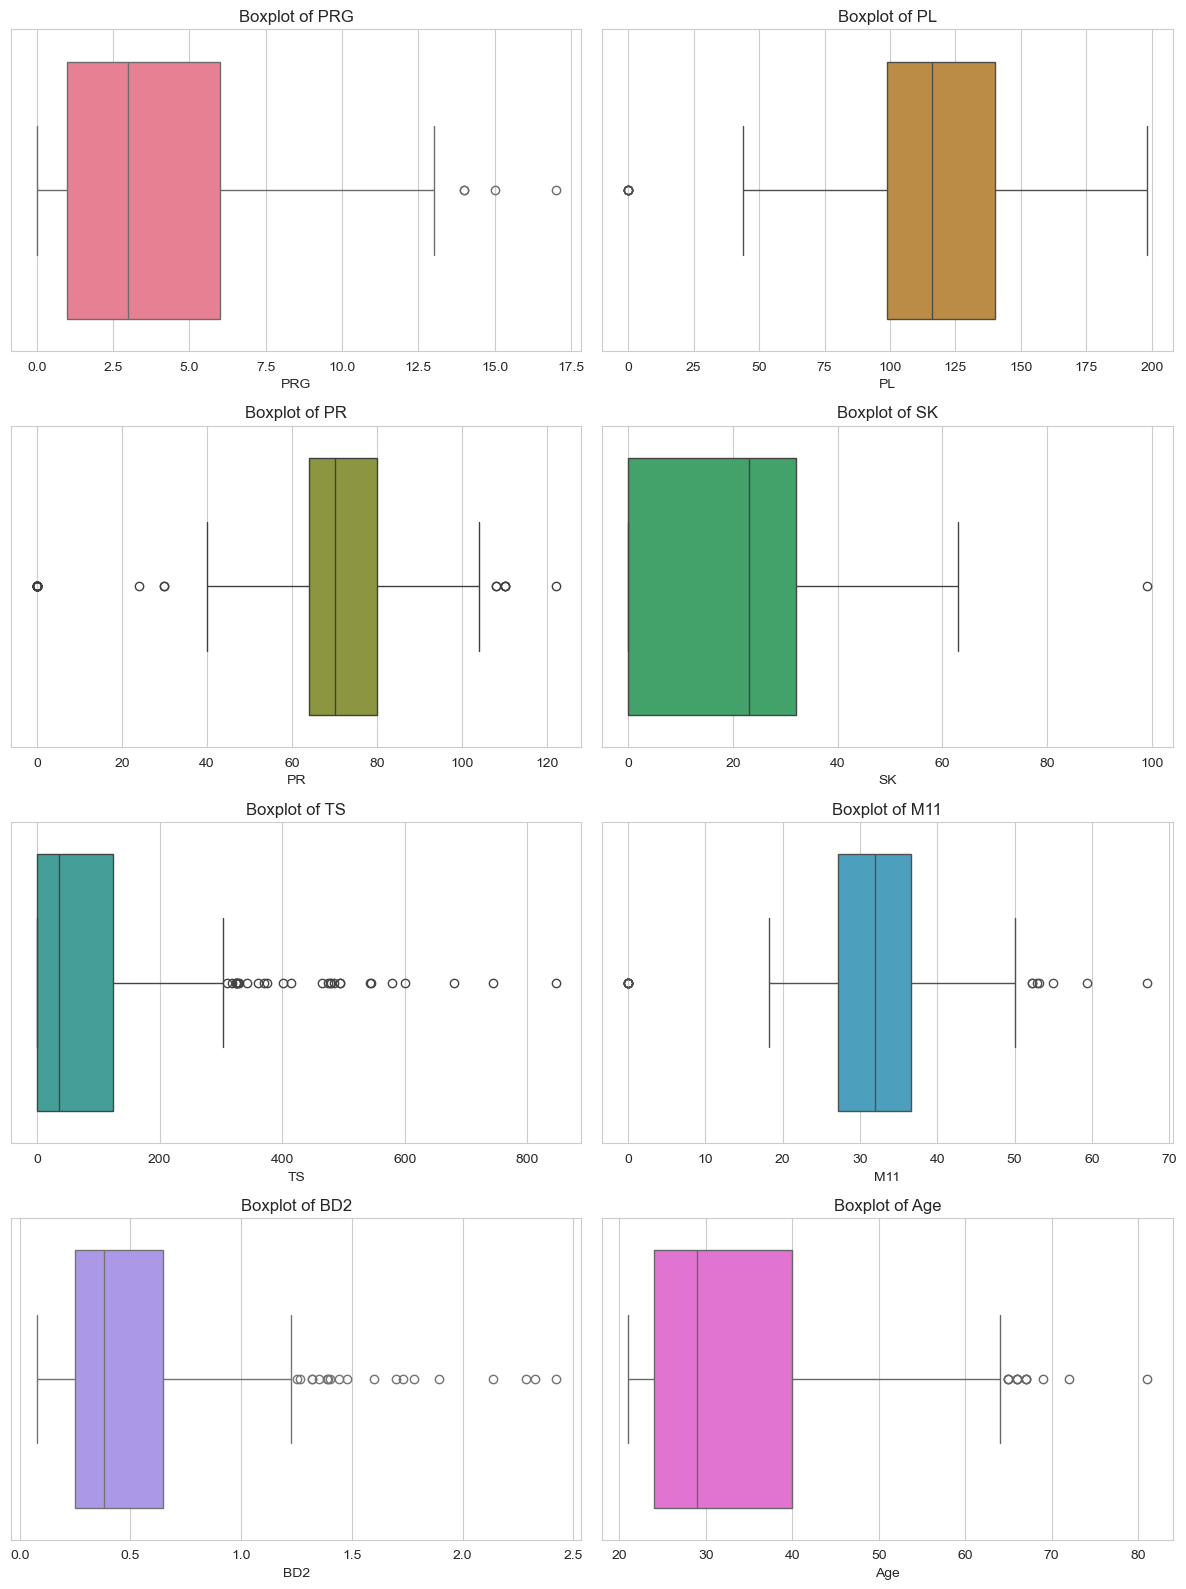

In [16]:
# Crie box plots para visualizar valores discrepantes (outliers)

data_without = df.drop(['ID', 'Insurance'], axis=1)

# Identify numeric columns
numeric_columns = data_without.select_dtypes(include=['number']).columns

# Set up subplots
num_rows = len(numeric_columns) // 2 + len(numeric_columns) % 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Define a color palette with different colors
colors = sns.color_palette("husl", n_colors=len(numeric_columns))

# Iterate over columns and create boxplots for numeric columns with different colors
for i, (column, color) in enumerate(zip(numeric_columns, colors)):
    sns.boxplot(x=data_without[column], ax=axes[i], orient='h', color=color)
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)

# Remove empty subplots if the number of subplots is odd
if len(numeric_columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Análise Bivariada

Perguntas analíticas

* Como é a distribuição da glicose plasmática (PRG) entre os pacientes que desenvolvem sepse e aqueles que não desenvolvem?

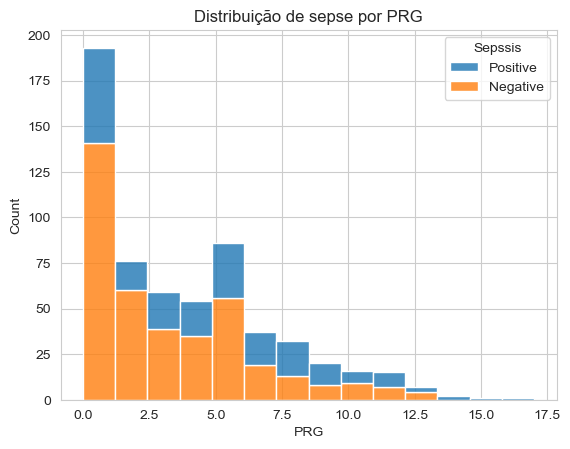

In [17]:
sns.histplot(x='PRG', hue='Sepssis', data=df, bins=14, alpha=0.8, multiple='stack')
plt.title('Distribuição de sepse por PRG')
plt.show()

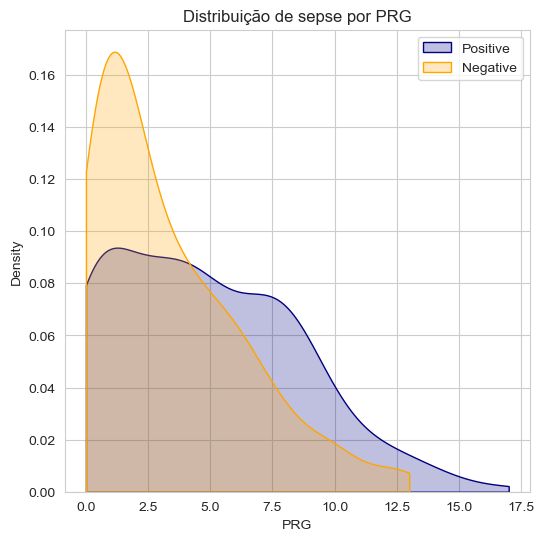

In [18]:
# Usamos uma distribuição de densidade de probabilidade para mostrar a distribuição de sepse relacionada ao PRG

def kdeplot(x):
    plt.figure(figsize=(6,6))
    plt.title('Distribuição de sepse por PRG')
    ax0= sns.kdeplot(df[df['Sepssis'] == 'Positive'][x], color='navy', label='Sepssis:Yes', fill =True, cut=0)
    ax1= sns.kdeplot(df[df['Sepssis'] == 'Negative'][x], color='orange', label='Sepssis:No', fill=True, cut=0)
    plt.legend(['Positive', 'Negative'], loc='upper right')
kdeplot('PRG')

2. Qual é a correlação entre a pressão arterial (RP) e a probabilidade de desenvolvimento de sepse?

Coeficiente de correlação: 0.06108646368071457
P-value: 0.13535052825595778


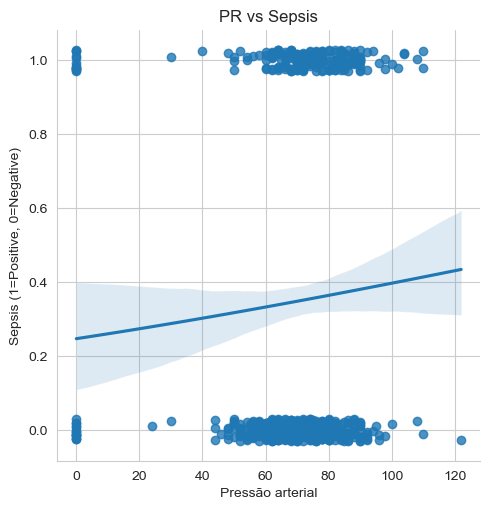

In [20]:
# Calcule a correlação ponto-bisserial
corr, p_value = pointbiserialr(df_copy["PR"], df_copy["Sepssis"])

# Print coeficiente de correlação e o p-value
print("Coeficiente de correlação:", corr)
print("P-value:", p_value)

# Plote os pontos de dados e visualize
# regressão logística para variável dependente binária

sns.lmplot(data=df_copy, x="PR", y="Sepssis", logistic=True, y_jitter=.03)
plt.xlabel("Pressão arterial")
plt.ylabel("Sepsis (1=Positive, 0=Negative)")
plt.title("PR vs Sepsis")
plt.show()

3. Existem diferenças perceptíveis no índice de massa corporal (M11) entre pacientes com e sem sepse?

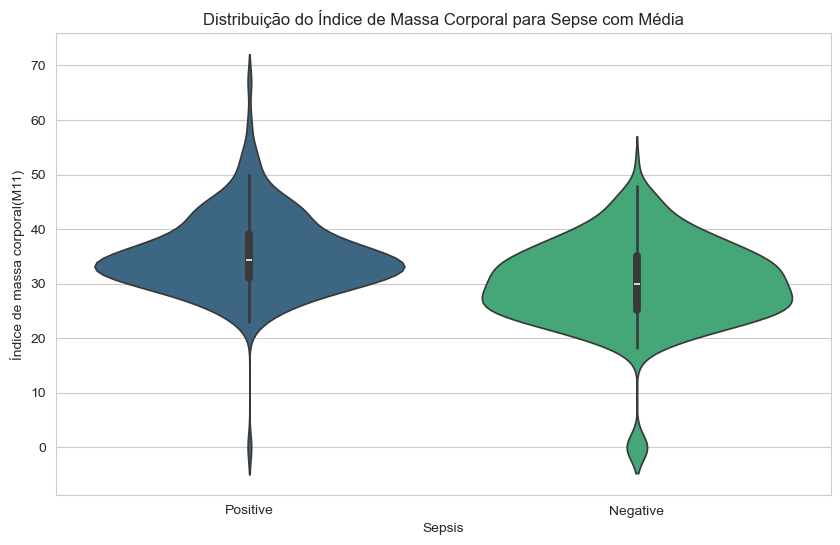

In [21]:
# Comparação da distribuição do índice de massa corporal dos pacientes dos dois grupos usando gráficos de violino.

plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Sepssis'], y=df['M11'], palette='viridis')

# Set labels and title
plt.xlabel('Sepsis')
plt.ylabel('Índice de massa corporal(M11)')
plt.title('Distribuição do Índice de Massa Corporal para Sepse com Média')
plt.show()

* Tanto o IMC dos casos de sepse positivos quanto os negativos estão concentrados em torno da mediana.
* Os casos positivos de sepse coincidem com um IMC mais elevado do que os casos negativos

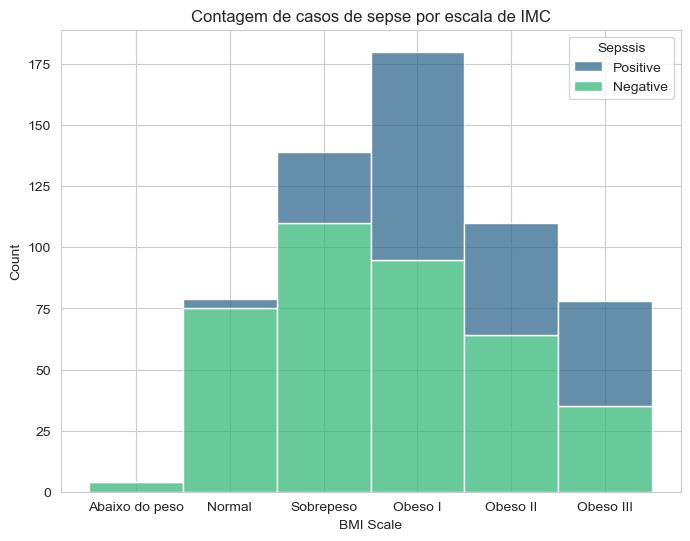

In [22]:
df_temp = df.copy()
df_temp['BMI_Scale'] = pd.cut(df['M11'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                    labels=['Abaixo do peso', 'Normal', 'Sobrepeso', 'Obeso I', 'Obeso II', 'Obeso III'])

plt.figure(figsize=(8, 6))
sns.histplot(x='BMI_Scale', hue='Sepssis', data=df_temp, multiple='stack', palette='viridis')

# Set labels and title
plt.xlabel('BMI Scale')
plt.ylabel('Count')
plt.title('Contagem de casos de sepse por escala de IMC')

# Show the plot
plt.show()